# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

### **Notebook 1 - Data Cleaning & EDA**

1. Data Cleaning & Processing
    * Duplicates & Missing Values
    * New Features
    * Weather dataframe (meteostat)
    * Passenger dataframe (eurostats)
    * Merge dataframes (Flight schedule, Weather and Total Passengers)
2. Exploratory Data Analysis
    * Flight Status
    * Flight Performance
    * Time Window
    * Flight Category Comparison
    * Airline Delays
    * Frequent Routes and Airports


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from core.DataLoader import DataLoader
from core.EDA.DataProcessing import DataProcessing
from core.EDA.FlightPerformance import FlightPerformance
from core.EDA.WeatherData import WeatherData
from core.EDA.MergeData import MergeData
from core.EDA.PassengerData import PassengerData
from avstats.core.general_utils import *

In [2]:
data_loader = DataLoader(config_path='config.yaml')
df_avstats, df_passengers, airport_mapping = data_loader.load_data()

if df_avstats is None or df_passengers is None or airport_mapping is None:
    raise SystemExit("Data files are missing or failed to load. Please check your configuration.")

### **1. Data Cleaning & Processing**
    
##### **Duplicates & Missing Values**

These are the changes made to fill out all the missing values in the dataset.
* Delay minutes NaN -> 0
* Actual departure time (adt) NaN -> Calculate it based on scheduled departure time (sdt) and delay minutes
* Actual arrival time (aat) NaN -> Calculate it based on scheduled arrival time (sat) and delay minutes
* When private flight -> Airline code and flight number as NONE
* Calculate the NaN values for both the calculated scheduled and actual flight time
    
##### **New Features**

1. Binary column for delays (dep_delay_15): delayed over 15min. (1) or not delayed (0)      
2. Categorize delays (dep_delay_cat): short under 15 min., medium 15 - 60 min. or long over 60 min.
3. Flight category (flight_cat): cargo, commercial, or private.
4. Set dep & arr times into time windows (dep_time_window & arr_time_window):
    * Morning (00:00 to 11:59)
    * Afternoon (12:00 to 17:59)
    * Night (18:00 to 23:59)

In [3]:
data_processing = DataProcessing(df_avstats, unique_column='uuid')
df = data_processing.preprocess_avstats()
negative_dep_delay_rows = df[df['dep_delay'] < 0] # Filter rows where 'dep_delay' is negative (on time flights)
df.head()

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,...,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km,dep_delay_15,dep_delay_cat,flight_cat,dep_time_window,arr_time_window,on_time_15
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,65.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,AT1688,175.0,153.0,1864.7,0,Short,Commercial,Afternoon,Afternoon,1
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,SK1594,90.0,90.0,754.4,0,Short,Commercial,Afternoon,Afternoon,1
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,SN3778,135.0,115.0,1359.5,1,Medium,Commercial,Afternoon,Afternoon,0
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,RO373,170.0,171.0,1754.8,1,Long,Commercial,Afternoon,Evening,0


In [4]:
# Analyze Data Quality
quality_metrics = data_processing.check_missing_and_duplicates(df)
print("Missing Values:", quality_metrics['missing_values'])
print("Duplicate Rows:", quality_metrics['duplicate_rows'])
print("Missing by Column:", quality_metrics['missing_by_column'])

Missing Values: 0
Duplicate Rows: None
Missing by Column: Series([], dtype: int64)


#### **1.2. Weather dataframe (meteostat)**
* Create new latitude and longitude (coordinate) columns for both departure and arrival airports
* Fetch weather data based on the route and date
* Handle missing values by dropping flights with missing temperatures and filling the rest with 0

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)
weather_fetcher = WeatherData(df)
weather_fetcher.assign_coordinates().head()
weather_fetcher.fetch_weather_data()
df_weather_merged = weather_fetcher.merge_weather_with_flights()

Assigning coordinates...
Starting weather data fetch for 807 coordinate pairs from 2023-01-01 00:00:00 to 2024-01-01 00:00:00.
Fetched weather for 900 / 807 coordinates.
Fetched weather for 1200 / 807 coordinates.
Fetched weather for 200 / 807 coordinates.
Fetched weather for 600 / 807 coordinates.
Fetched weather for 182600 / 807 coordinates.
Fetched weather for 204400 / 807 coordinates.
Weather data fetching completed with 285304 records.
adt and aat were successfully turned into datetime format.
Weather data was merged with schedule data successfully.


In [6]:
# Remove duplicates from the duplicate_rows DataFrame
df_weather_merged = df_weather_merged.drop_duplicates()

# Drop rows where 'tavg_dep' has missing values
df_weather_merged = df_weather_merged.dropna(subset=['tavg_dep', 'tavg_arr'])

# Convert categorical columns to strings
df_weather_merged = df_weather_merged.apply(lambda col: col.astype(str) if col.dtype.name == 'category' else col)

# Fill all missing values with 0
df_weather_merged.fillna(0, inplace=True)
df_weather_merged

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,...,tmax_arr,prcp_arr,snow_arr,wdir_arr,wspd_arr,wpgt_arr,pres_arr,tsun_arr,arr_lat_y,arr_lon_y
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,22.7,0.0,0.0,160.0,12.8,31.5,1014.8,0.0,55.6179,12.65600
4,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444
8,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,...,22.7,0.0,0.0,160.0,12.8,31.5,1014.8,0.0,55.6179,12.65600
12,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444
16,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,...,25.6,1.0,0.0,252.0,10.5,27.8,1016.0,0.0,50.9014,4.48444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336484,5BFEF3E39CACFCC7180DFAED2D5371C7DE423459,BRU-DJE,ARRIVAL,ACTIVE,BRU,20.0,2023-08-15 13:35:00+00:00,2023-08-15 13:54:00+00:00,DJE,2023-08-15 16:55:00+00:00,...,32.0,0.0,0.0,90.0,17.3,0.0,1015.6,0.0,33.8750,10.77550
1336488,83E13A7218F696B892BA520B29FF65919B0F58AC,BRU-TNG,ARRIVAL,LANDED,BRU,20.0,2023-08-15 13:40:00+00:00,2023-08-15 13:59:00+00:00,TNG,2023-08-15 17:05:00+00:00,...,29.8,0.0,0.0,282.0,9.2,25.9,1013.4,0.0,35.7269,-5.91689
1336492,4ED24DBA03246DB7CBD3CB23AEA4EDE531119E08,BRU-LIN,ARRIVAL,LANDED,BRU,31.0,2023-08-15 13:45:00+00:00,2023-08-15 14:16:00+00:00,LIN,2023-08-15 15:10:00+00:00,...,33.3,0.0,0.0,43.0,5.5,18.5,1017.0,0.0,45.4451,9.27674
1336496,98626013D1BB61DB09DBAAEDDC3C791F7BE82A66,BRU-BCN,ARRIVAL,LANDED,BRU,43.0,2023-08-15 13:50:00+00:00,2023-08-15 14:32:00+00:00,BCN,2023-08-15 15:55:00+00:00,...,30.1,0.0,0.0,67.0,14.4,29.6,1015.7,0.0,41.2971,2.07846


In [7]:
# Initialize the aggregator
aggregator = MergeData(df_weather_merged)

# Preprocess the datetime column (assume 'sdt' is the column name)
aggregator.preprocess_datetime()

# Aggregate daily
df_grouped_daily = aggregator.aggregate_daily(passenger_data=False)
df_grouped_daily

,route_iata_code,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,avg_pres_dep,total_tsun_dep,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr
0,AAL-BRU,2023-09-09,5,3,2,1,3,1,576.0,4,...,1016.4,0.0,23.3,0.0,0.0,94.0,4.5,18.5,1017.0,0.0
1,ABJ-BRU,2023-01-01,2,1,1,1,1,0,80.0,2,...,1011.0,0.0,10.1,14.4,0.0,233.0,19.4,44.5,1017.1,0.0
2,ABJ-BRU,2023-01-04,2,1,1,1,1,0,72.0,2,...,1011.4,0.0,11.0,2.2,0.0,244.0,20.4,46.3,1021.0,0.0
3,ABJ-BRU,2023-01-06,2,1,1,1,1,0,88.0,2,...,1012.0,0.0,10.3,0.2,0.0,194.0,24.3,46.3,1010.4,0.0
4,ABJ-BRU,2023-01-08,2,1,1,1,1,0,48.0,2,...,1011.7,0.0,6.7,1.0,0.0,237.0,23.0,46.3,1000.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,ZTH-BRU,2023-10-14,2,1,1,1,1,0,18.0,0,...,1016.9,0.0,12.1,8.4,0.0,259.0,20.7,48.2,1013.2,0.0
74934,ZTH-BRU,2023-10-15,2,1,1,1,1,0,34.0,2,...,1013.1,0.0,8.3,2.2,0.0,258.0,13.1,29.6,1022.7,0.0
74935,ZTH-BRU,2023-10-21,2,1,1,1,1,0,32.0,2,...,1015.0,0.0,13.4,1.8,0.0,190.0,24.0,51.8,990.2,0.0
74936,ZTH-BRU,2023-10-22,2,1,1,1,1,0,24.0,0,...,1015.8,0.0,12.6,5.8,0.0,219.0,15.0,51.8,1005.6,0.0


In [8]:
save_dataframe(df_grouped_daily, "df_weather")

DataFrame saved to ..\data\df_weather.csv


#### **1.4. Passenger dataframe (External data from Eurostats)**

Air passenger based on partner airports and the BRU International Airport routes (ec.europa.eu).

In [10]:
passengers = PassengerData(df_passengers, airport_mapping)
df_passengers_cleaned = passengers.process_passenger_data()
aggregator.aggregate_daily(passenger_data=True)
df_merged = aggregator.aggregate_passengers(df_passengers_cleaned)
df_merged

,route_iata_code,Month,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,total_tsun_dep,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr,total_passengers
0,BRU-ACC,2023-01,42,21,21,18,21,3,1529.0,36,...,0.0,28.604762,9.5,0.000000,219.404762,12.921429,0.000000,1010.616667,0.0,10006
1,BRU-ACC,2023-02,35,19,16,14,19,2,1206.0,25,...,0.0,29.265714,10.5,0.000000,199.257143,13.960000,0.000000,1009.900000,0.0,8645
2,BRU-ACC,2023-03,46,22,24,17,22,7,1544.0,37,...,0.0,28.656522,55.6,0.000000,220.304348,13.467391,0.000000,1010.054348,0.0,10371
3,BRU-ACC,2023-04,37,18,19,15,18,4,1380.0,32,...,0.0,29.067568,62.9,0.000000,224.189189,14.245946,0.000000,1009.391892,0.0,11042
4,BRU-ACC,2023-05,39,18,21,17,18,2,1624.0,37,...,0.0,28.769231,165.4,0.000000,220.615385,11.605128,0.000000,1011.353846,0.0,10879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,BRU-ZRH,2023-08,222,109,113,87,109,26,8083.0,165,...,0.0,20.059459,946.6,0.000000,243.121622,7.890991,35.017117,1015.321622,0.0,25871
752,BRU-ZRH,2023-09,246,120,126,108,120,18,7941.0,177,...,0.0,17.932927,300.0,0.000000,236.792683,6.567073,28.096748,1017.884959,0.0,27551
753,BRU-ZRH,2023-10,270,135,135,130,135,5,6782.0,170,...,0.0,12.486667,558.7,0.000000,245.011111,8.712963,33.300741,1014.055926,0.0,27995
754,BRU-ZRH,2023-11,266,131,135,133,131,2,6157.0,158,...,0.0,6.135338,1646.5,1.353383,225.436090,11.951880,45.408271,1012.524060,0.0,26911


In [11]:
save_dataframe(df_merged, "df_merged")

DataFrame saved to ..\data\df_merged.csv


In [12]:
df_weather = df_weather_merged.copy()
df_no_passengers = df_grouped_daily.copy()
df_passengers = df_merged.copy()

### **2. Exploratory Data Analysis (EDA)**



Meaning of the different dataframes used through the exploratory data analysis.

df. Original 2023 flight schedule dataset with cleaned data | 340k rows; one for each flight

df_weather. Same but with the weather conditions for departure and arrival airports | 332k rows; one for each flight

df_no_passengers. Flights are grouped daily per route | 75k rows; one for each day per route

df_passengers. Flights are grouped monthly per route | 756 rows; one per month per route


#### **Approach**

1. What are the most common flight routes in the dataset?
2. Which routes experience the highest delays?
3. How does weather impact departure and arrival delays?
4. Are there patterns in delays across different times of the day, week, or month?
5. What percentage of flights are on time, delayed, or canceled?

#### **2.1. The most common flight routes**

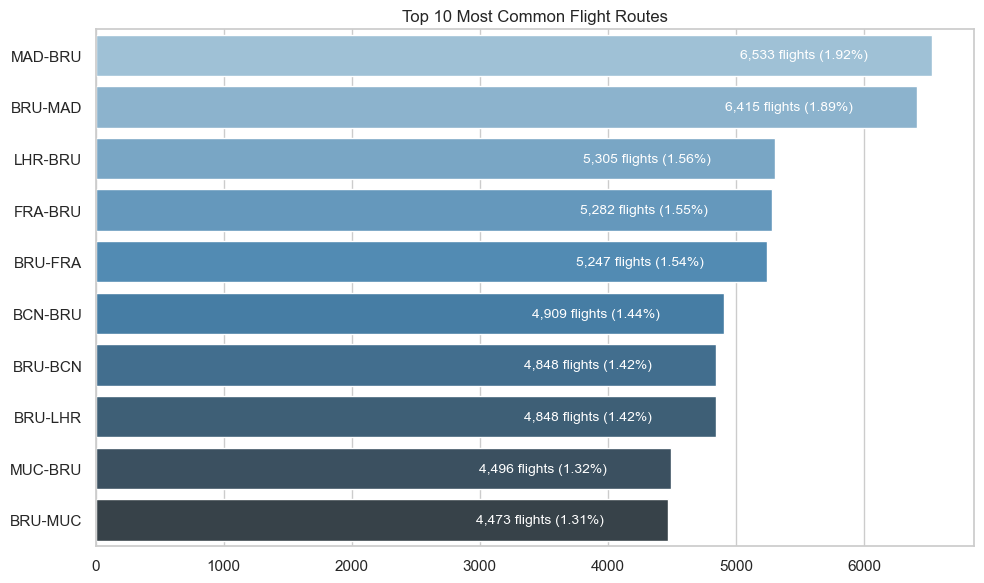

In [237]:
# Most Common Routes
common_routes = df['route_iata_code'].value_counts().head(10)
common_routes_percentage = (common_routes / df['route_iata_code'].count() * 100).round(2)

# Visualize Most Common Routes with Improved Annotation
plt.figure(figsize=(10, 6))
sns.barplot(x=common_routes.values, y=common_routes.index, palette='Blues_d')
plt.title('Top 10 Most Common Flight Routes')
plt.xlabel('')
plt.ylabel('')

# Annotate bars with percentages and ensure text fits within the plot
for i, (v, p) in enumerate(zip(common_routes.values, common_routes_percentage)):
    plt.text(v - 500, i, f"{v:,} flights ({p}%)", color='white', ha='right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

#### **2.2. Routes with the highest delays**

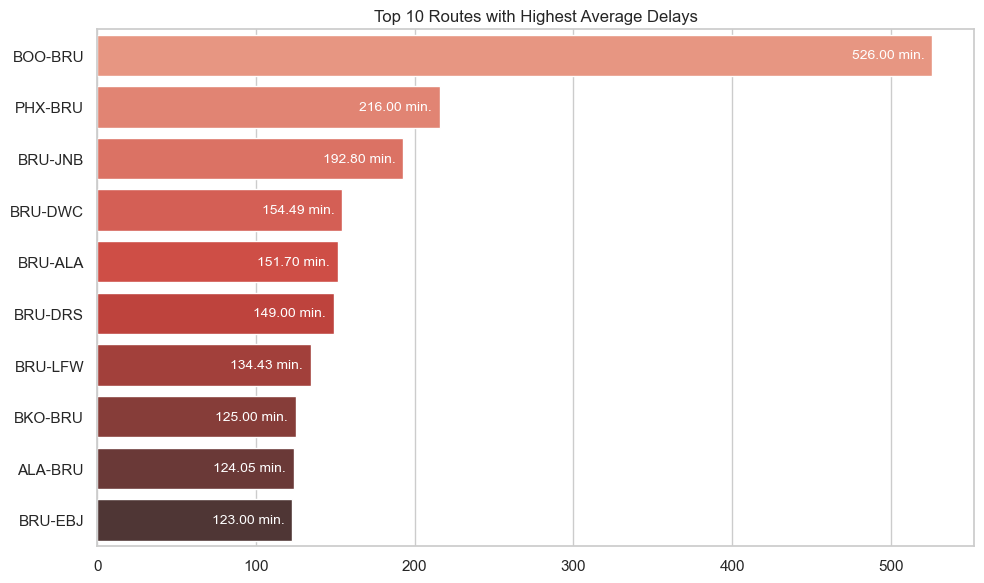

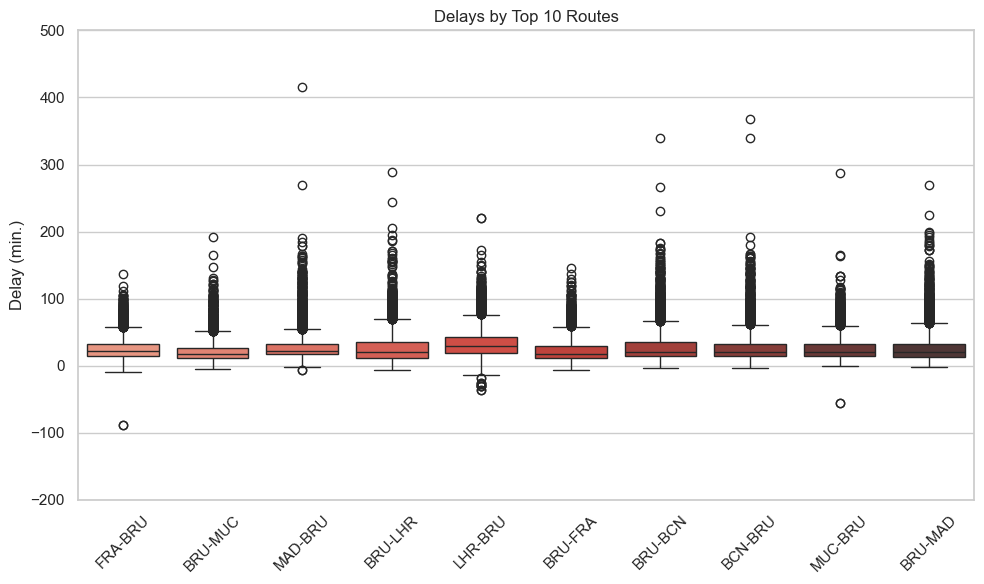

In [238]:
# Calculate Average Delay by Route
average_delay_sorted = df.groupby('route_iata_code')['dep_delay'].mean().sort_values(ascending=False).reset_index()
average_delay_sorted.columns = ['route_iata_code', 'average_dep_delay']

# Visualize Top 10 Routes with Highest Delays with Annotations
plt.figure(figsize=(10, 6))
sns.barplot(data=average_delay_sorted.head(10), x='average_dep_delay', y='route_iata_code', palette='Reds_d')
plt.title('Top 10 Routes with Highest Average Delays')
plt.xlabel('')
plt.ylabel('')

# Text annotations
for index, row in average_delay_sorted.head(10).iterrows():
    plt.text(row['average_dep_delay'] - 5, index, f"{row['average_dep_delay']:.2f} min.", color='white', ha='right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Boxplot of Delays for Top 10 Routes
top_routes = df['route_iata_code'].value_counts().nlargest(10).index
filtered_df = df[df['route_iata_code'].isin(top_routes)]
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='route_iata_code', y='dep_delay', palette='Reds_d')
plt.title('Delays by Top 10 Routes')
plt.xlabel('')
plt.ylabel('Delay (min.)')
plt.xticks(rotation=45)
plt.ylim(-200, 500)
plt.tight_layout()
plt.show()

#### **2.3. Weather impact departure and arrival delays**

precipitation_level
No Precipitation    173122
Light Rain          135867
Moderate Rain        22083
Heavy Rain            1191
Name: count, dtype: int64


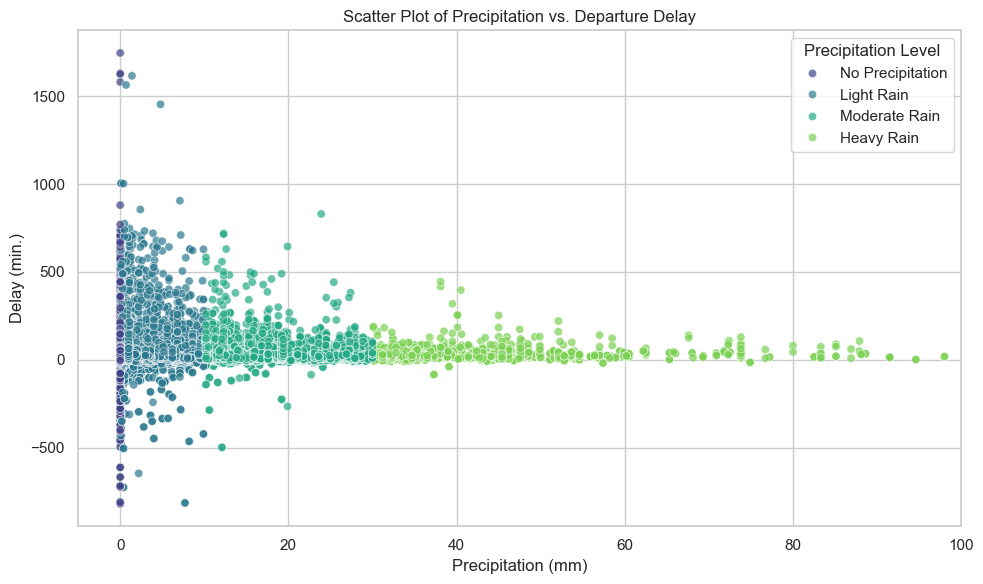

In [239]:
# Categorize Precipitation Levels
df_weather['precipitation_level'] = pd.cut(
    df_weather['prcp_dep'],
    bins=[-0.1, 0, 10, 30, float('inf')],  # Adjust bins for proper range
    labels=['No Precipitation', 'Light Rain', 'Moderate Rain', 'Heavy Rain'],  # Correct number of labels
    include_lowest=True  # Include the lowest bound in the first bin
)

# Check the distribution of precipitation levels
print(df_weather['precipitation_level'].value_counts())

# Visualize Delays by Precipitation Level
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_weather, x='prcp_dep', y='dep_delay', hue='precipitation_level', palette='viridis', alpha=0.7)
plt.title('Scatter Plot of Precipitation vs. Departure Delay')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Delay (min.)')
plt.legend(title='Precipitation Level')
plt.xlim(-5, 100)
plt.tight_layout()
plt.show()

#### **2.4. Patterns in delays across different times**

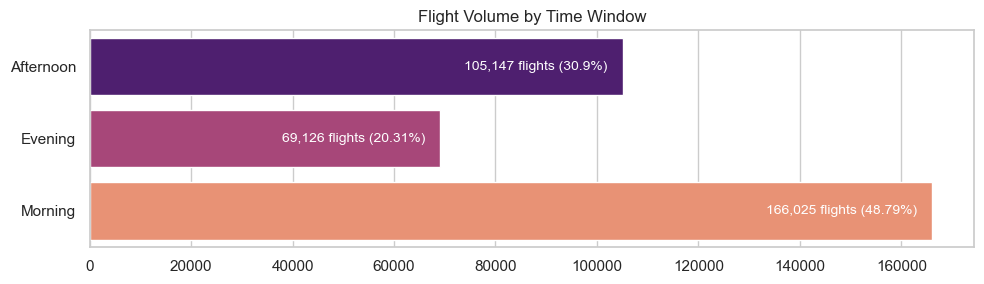

In [318]:
# Flight Volume by Time of Day
flight_summary = df.groupby('dep_time_window')['uuid'].count()
flight_summary_percentage = (flight_summary / df['dep_time_window'].count() * 100).round(2)

plt.figure(figsize=(10, 3))
ax = sns.barplot(x=flight_summary.values, y=flight_summary.index, palette='magma')
plt.title('Flight Volume by Time Window')
plt.xlabel('')
plt.ylabel('')

# Text annotations
for i, (v, p) in enumerate(zip(flight_summary.values, flight_summary_percentage)):
    ax.text(v - 3000, i, f"{v:,} flights ({p}%)", color='white', ha='right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

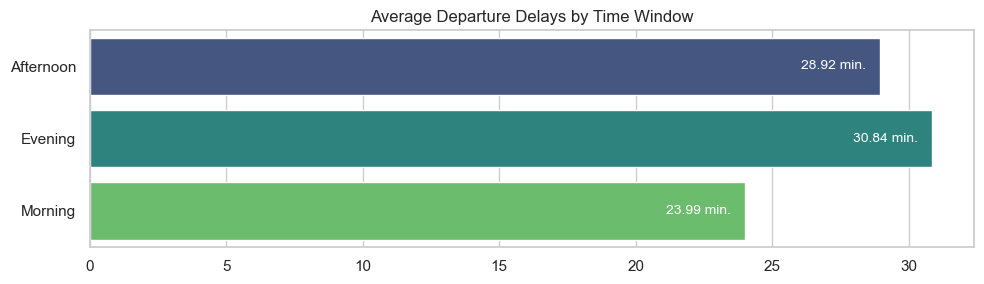

In [287]:
# Delays by Time of Day
time_of_day_delays = df.groupby('dep_time_window')['dep_delay'].mean()
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=time_of_day_delays.values, y=time_of_day_delays.index, palette='viridis')
plt.title('Average Departure Delays by Time Window')
plt.xlabel('')
plt.ylabel('')

# Text annotations
for index, value in enumerate(time_of_day_delays.values):
    ax.text(value - 0.5, index, f"{value:.2f} min.", color='white', ha='right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

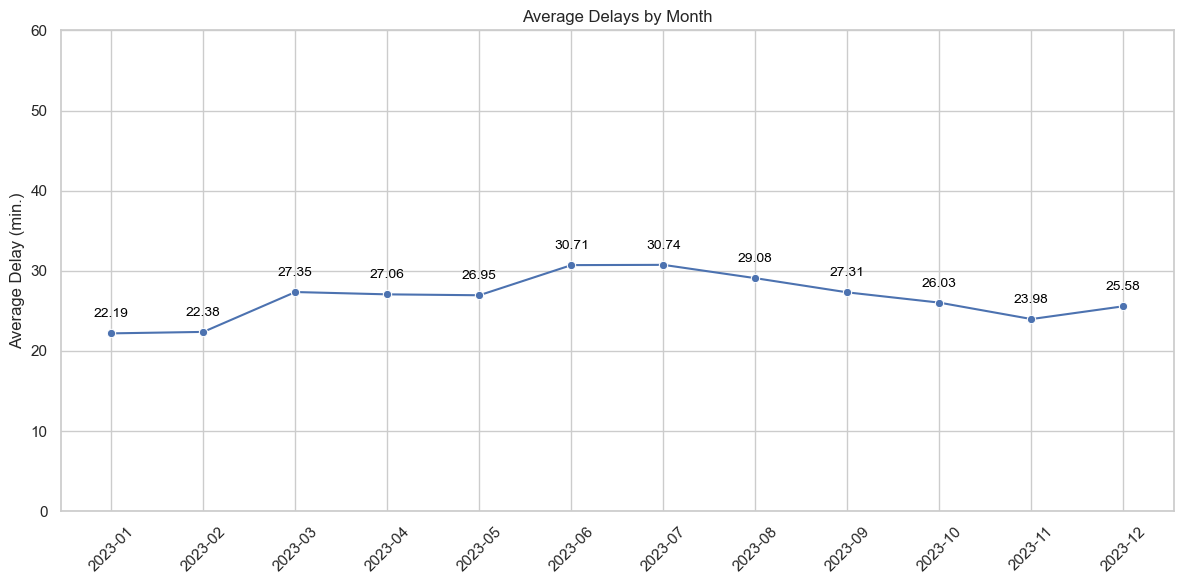

In [315]:
# Delays by Month with Annotations
df['Month'] = pd.to_datetime(df['sdt']).dt.to_period('M')
monthly_delays = df.groupby('Month')['dep_delay'].mean()

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=monthly_delays.index.astype(str), y=monthly_delays.values, marker='o')
plt.title('Average Delays by Month')
plt.xlabel('')
plt.ylabel('Average Delay (min.)')
plt.xticks(rotation=45)
plt.ylim(0, 60)

# Text annotations
for i, (x, y) in enumerate(zip(monthly_delays.index.astype(str), monthly_delays.values)):
    ax.text(x, y + 2, f"{y:.2f}", color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

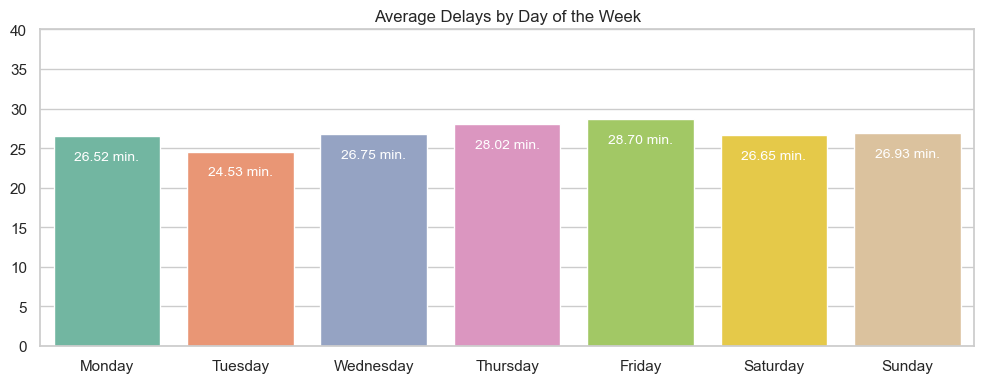

In [298]:
# Delays by Day of Week
df['DayOfWeek'] = pd.to_datetime(df['sdt']).dt.day_name()
weekday_delays = df.groupby('DayOfWeek')['dep_delay'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 4))
ax=sns.barplot(x=weekday_delays.index, y=weekday_delays.values, palette='Set2')
plt.title('Average Delays by Day of the Week')
plt.xlabel('')
plt.ylabel('')

# Add text annotations on the bars
for index, value in enumerate(weekday_delays.values):
    ax.text(index, value - 3, f"{value:.2f} min.", color='white', ha='center', fontsize=10)

plt.ylim(0, 40)
plt.tight_layout()
plt.show()

#### **2.5. Percentage of flights on time, delayed, or with a missing status**

Bar Chart for Overall Performance:
* Presents the proportions of delayed, on-time, and missing-status flights in a visually appealing manner.
* Includes labels for percentages on each bar for clarity.

Bar Chart for Delay Ranges:
* Illustrates the distribution of delays across different ranges.
* Helps identify where most delays fall and their relative impact.

Overall Flight Performance Percentage:
Delayed Flights (%): 64.05%
On-Time Flights (%): 32.31%
Missing Status (%): 3.64%


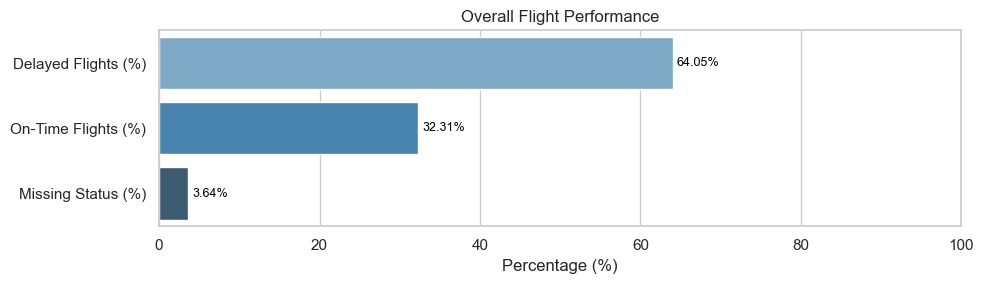

In [278]:
# Performance Summary
flight_performance = FlightPerformance(df)
performance_metrics = flight_performance.overall_performance()
print("Overall Flight Performance Percentage:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2f}%")
    
# Visualize Overall Flight Performance
performance_labels = list(performance_metrics.keys())
performance_values = list(performance_metrics.values())
plt.figure(figsize=(10, 3))
sns.barplot(x=performance_values, y=performance_labels, palette='Blues_d')
plt.xlabel("Percentage (%)")
plt.title("Overall Flight Performance")
plt.xlim(0, 100)

for i, v in enumerate(performance_values):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', color='black', fontsize=9)
    
plt.tight_layout()
plt.show()

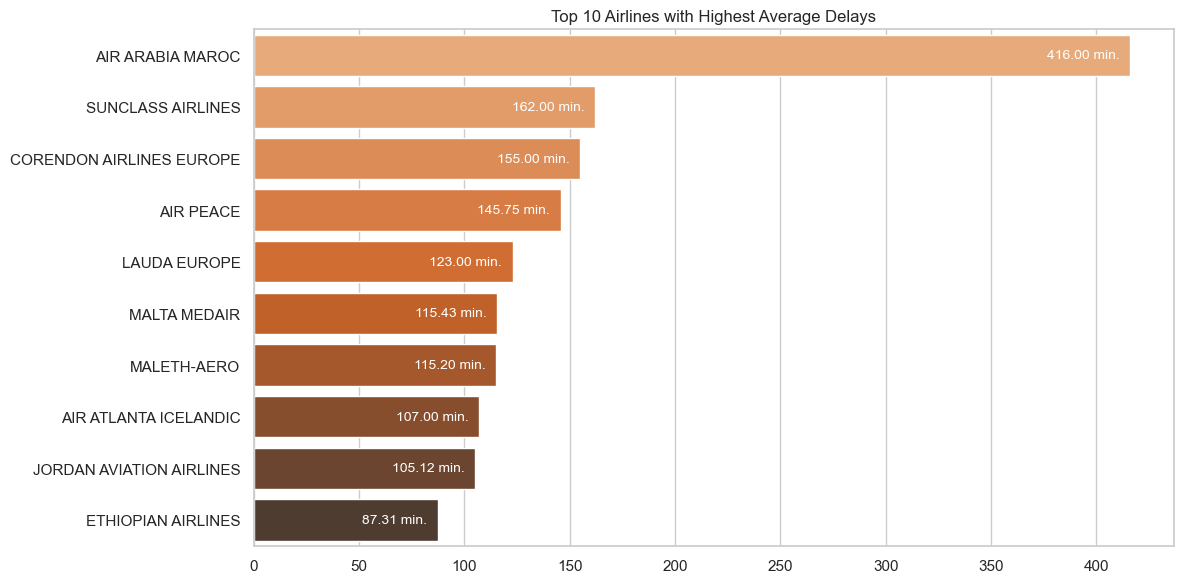

In [285]:
# Airline Delay Performance
airline_delays = df.groupby('airline_name')['dep_delay'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=airline_delays.head(10), x='dep_delay', y='airline_name', palette='Oranges_d')
plt.title('Top 10 Airlines with Highest Average Delays')
plt.xlabel('')
plt.ylabel('')

# Text annotations
for index, row in airline_delays.head(10).iterrows():
    plt.text(row['dep_delay'] - 5, index, f"{row['dep_delay']:.2f} min.", color='white', ha='right', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Delay Summary:
Delays 0-60 minutes: 91.00%
Delays 60-120 minutes: 5.67%
Delays 120-180 minutes: 0.82%
Delays 180-inf minutes: 0.44%


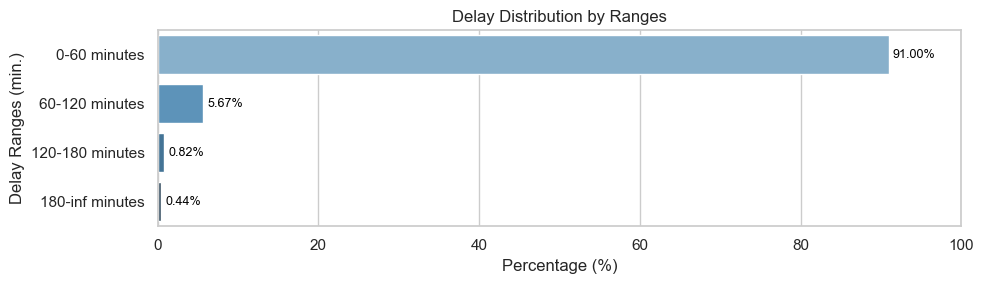

In [281]:
# Delay Ranges
delay_ranges = [(0, 60), (60, 120), (120, 180), (180, float('inf'))]
delay_summary = flight_performance.delay_ranges_summary(delay_ranges)
print("\nDelay Summary:")
for range_label, percentage in delay_summary.items():
    print(f"Delays {range_label}: {percentage:.2f}%")
    
# Visualize Delay Summary
delay_labels = list(delay_summary.keys())
delay_values = list(delay_summary.values())
plt.figure(figsize=(10, 3))
sns.barplot(x=delay_values, y=delay_labels, palette='Blues_d')
plt.xlabel("Percentage (%)")
plt.ylabel("Delay Ranges (min.)")
plt.title("Delay Distribution by Ranges")
plt.xlim(0, 100)
for i, v in enumerate(delay_values):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', color='black', fontsize=9)
plt.tight_layout()
plt.show()